# Explainability of a Random Forest Classifier

... in the context of a toy sklearn dataset. 

🔍 Scenario
Patient X received a benign classification from an AI tumor diagnostic tool and was not referred for a biopsy. Months later, the tumor was diagnosed as malignant. The model’s output is now under scrutiny.

**Task:** Defend the decision with reference to the model’s logic and learned feature importance. Consider how this decision aligns with the broader data trends.

Download the and split the UCI ML Wisconsin Breast Cancer Dataset (WBCD), see https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset. Problem set-up from [Duke XAI ML court notebook](https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/assignments/machine_learning_court.ipynb). 

In [1]:
from matplotlib import pyplot as plt 
import seaborn as sns

## Exploratory Data Analysis

In [2]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

# Load dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target  # 0 = malignant, 1 = benign

Inspect the dataset and feature data types. 

In [3]:
df

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0          17.99         10.38          122.80     1001.0          0.11840   
1          20.57         17.77          132.90     1326.0          0.08474   
2          19.69         21.25          130.00     1203.0          0.10960   
3          11.42         20.38           77.58      386.1          0.14250   
4          20.29         14.34          135.10     1297.0          0.10030   
..           ...           ...             ...        ...              ...   
564        21.56         22.39          142.00     1479.0          0.11100   
565        20.13         28.25          131.20     1261.0          0.09780   
566        16.60         28.08          108.30      858.1          0.08455   
567        20.60         29.33          140.10     1265.0          0.11780   
568         7.76         24.54           47.92      181.0          0.05263   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
0             0.27760         0.30010              0.14710         0.2419   
1             0.07864         0.08690              0.07017         0.1812   
2             0.15990         0.19740              0.12790         0.2069   
3             0.28390         0.24140              0.10520         0.2597   
4             0.13280         0.19800              0.10430         0.1809   
..                ...             ...                  ...            ...   
564           0.11590         0.24390              0.13890         0.1726   
565           0.10340         0.14400              0.09791         0.1752   
566           0.10230         0.09251              0.05302         0.1590   
567           0.27700         0.35140              0.15200         0.2397   
568           0.04362         0.00000              0.00000         0.1587   

     mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                   0.07871  ...          17.33           184.60      2019.0   
1                   0.05667  ...          23.41           158.80      1956.0   
2                   0.05999  ...          25.53           152.50      1709.0   
3                   0.09744  ...          26.50            98.87       567.7   
4                   0.05883  ...          16.67           152.20      1575.0   
..                      ...  ...            ...              ...         ...   
564                 0.05623  ...          26.40           166.10      2027.0   
565                 0.05533  ...          38.25           155.00      1731.0   
566                 0.05648  ...          34.12           126.70      1124.0   
567                 0.07016  ...          39.42           184.60      1821.0   
568                 0.05884  ...          30.37            59.16       268.6   

     worst smoothness  worst compactness  worst concavity  \
0             0.16220            0.66560           0.7119   
1             0.12380            0.18660           0.2416   
2             0.14440            0.42450           0.4504   
3             0.20980            0.86630           0.6869   
4             0.13740            0.20500           0.4000   
..                ...                ...              ...   
564           0.14100            0.21130           0.4107   
565           0.11660            0.19220           0.3215   
566           0.11390            0.30940           0.3403   
567           0.16500            0.86810           0.9387   
568           0.08996            0.06444           0.0000   

     worst concave points  worst symmetry  worst fractal dimension  target  
0                  0.2654          0.4601                  0.11890       0  
1                  0.1860          0.2750                  0.08902       0  
2                  0.2430          0.3613                  0.08758       0  
3                  0.2575          0.6638                  0.17300       0  
4                  0.1625          0.2364                  0.076

In [4]:
df.dtypes

mean radius                float64
mean texture               float64
mean perimeter             float64
mean area                  float64
mean smoothness            float64
mean compactness           float64
mean concavity             float64
mean concave points        float64
mean symmetry              float64
mean fractal dimension     float64
radius error               float64
texture error              float64
perimeter error            float64
area error                 float64
smoothness error           float64
compactness error          float64
concavity error            float64
concave points error       float64
symmetry error             float64
fractal dimension error    float64
worst radius               float64
worst texture              float64
worst perimeter            float64
worst area                 float64
worst smoothness           float64
worst compactness          float64
worst concavity            float64
worst concave points       float64
worst symmetry      

All features are continuous, permute all the pairwise distributions to get a sense for (pairwise) relationships. 

⚠️ Note this cell can take a couple of minutes to run depending on the underlying compute. 

In [ ]:
sns.pairplot(df.drop(['target'], axis=1).sample(frac=0.1))

The distributions suggests are a number of correlated features of varying intensity. For example, radius is purely linearly correlated with perimeter as we would expect: 

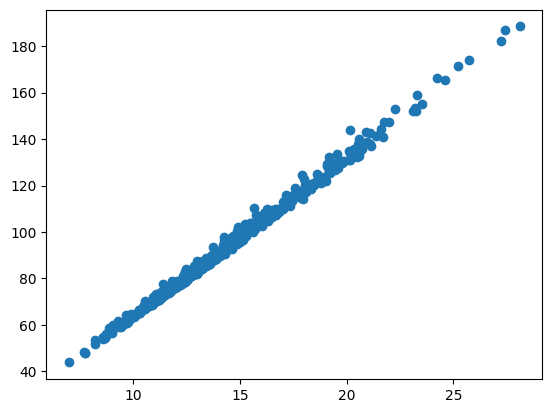

In [19]:
plt.scatter(x=df['mean radius'], y=df['mean perimeter'])

Look at the correlation matrix to quantify this. 

Text(0.5, 1.0, 'Feature correlation matrix')

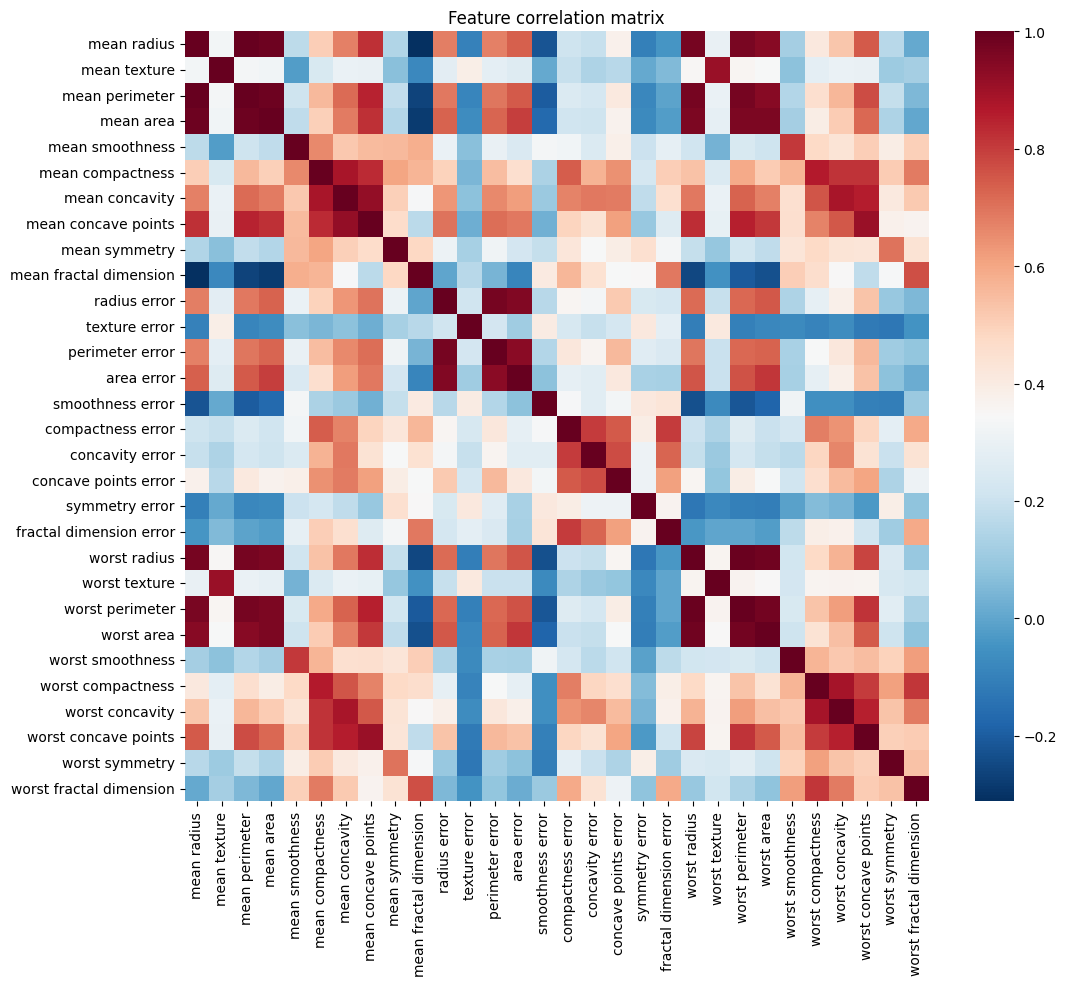

In [20]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
sns.heatmap(data=df.drop(columns=['target'],axis=1).corr(), ax=ax, cmap='RdBu_r')
ax.set_title("Feature correlation matrix")

We see groupings of strong correlations mostly among features that are based on the geometry of the analyzed mass. 

Now inspect how the potential predictors correlated with our target variable. 

Text(0.5, 1.0, 'Feature correlation with target variable')

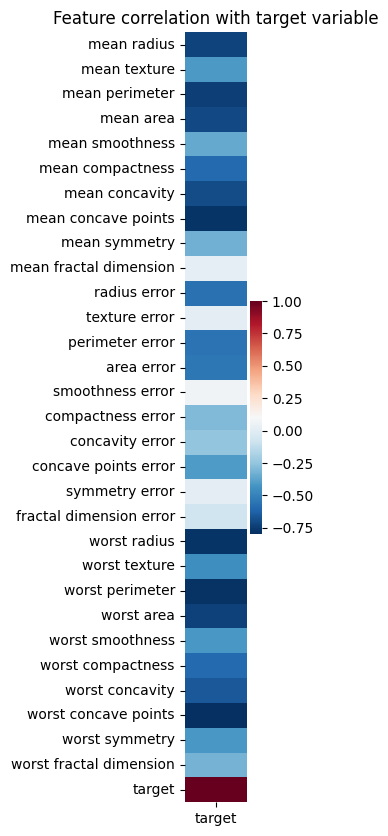

In [21]:
fig, ax = plt.subplots(1,1,figsize=(1,10))
sns.heatmap(df.corr()[['target']], cmap='RdBu_r', ax=ax)
ax.set_title('Feature correlation with target variable')

We see a strong correlation with a number of features, which suggests a potentially straightforward modeling process. 

## Modeling

Train a random forest model to predict the target variable. 

In [304]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [23]:
# Train/test split
X = df.drop("target", axis=1)
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [300]:
# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Inspect incorrect predictions in our training and test datasets. 

In [298]:
preds = model.predict(X_train)
X_train[y_train != preds]

Empty DataFrame
Columns: [mean radius, mean texture, mean perimeter, mean area, mean smoothness, mean compactness, mean concavity, mean concave points, mean symmetry, mean fractal dimension, radius error, texture error, perimeter error, area error, smoothness error, compactness error, concavity error, concave points error, symmetry error, fractal dimension error, worst radius, worst texture, worst perimeter, worst area, worst smoothness, worst compactness, worst concavity, worst concave points, worst symmetry, worst fractal dimension]
Index: []

[0 rows x 30 columns]

In [299]:
preds = model.predict(X_test)
X_test[y_test != preds]

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
81         13.34         15.86           86.49      520.0          0.10780   
73         13.80         15.79           90.43      584.1          0.10070   
255        13.96         17.05           91.43      602.4          0.10960   
86         14.48         21.46           94.25      648.2          0.09444   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
81            0.15350         0.11690              0.06987         0.1942   
73            0.12800         0.07789              0.05069         0.1662   
255           0.12790         0.09789              0.05246         0.1908   
86            0.09947         0.12040              0.04938         0.2075   

     mean fractal dimension  ...  worst radius  worst texture  \
81                  0.06902  ...         15.53          23.19   
73                  0.06566  ...         16.57          20.86   
255                 0.06130  ...         16.39          22.07   
86                  0.05636  ...         16.21          29.25   

     worst perimeter  worst area  worst smoothness  worst compactness  \
81             96.66       614.9            0.1536             0.4791   
73            110.30       812.4            0.1411             0.3542   
255           108.10       826.0            0.1512             0.3262   
86            108.40       808.9            0.1306             0.1976   

     worst concavity  worst concave points  worst symmetry  \
81            0.4858                0.1708          0.3527   
73            0.2779                0.1383          0.2589   
255           0.3209                0.1374          0.3068   
86            0.3349                0.1225          0.3020   

     worst fractal dimension  
81                   0.10160  
73                   0.10300  
255                  0.07957  
86                   0.06846  

[4 rows x 30 columns]

The ensemble learned to perfectly separate our training data, and while it generalizes well, it is clearly an imperfect classifier for unseen samples. 

In [301]:
print(classification_report(y_test, model.predict(X_test))) 

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



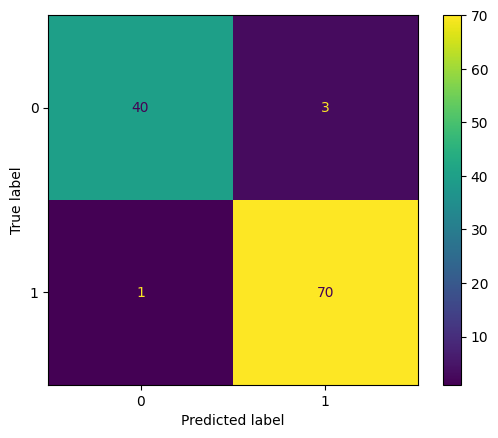

In [305]:
ConfusionMatrixDisplay(confusion_matrix(y_test, preds)).plot()

## Explaining the Model

We'll use the SHapley Additive exPlanations (SHAP) library to *approximate* the shapley values of our predictors. This yields insight into the degree to which a feature influences the target prediction over the average prediction. 

**Background**

Notionally, SHAP [carries out the following steps](https://christophm.github.io/interpretable-ml-book/shap.html#kernelshap): 
1. Permute a list of binary feature masks that will turn the corresponding feature 'on' (`mask = 1`) or 'off' (`mask = 0`). The resulting vectors capture the *coalitions* of features that will be employed to help explain their importance. E.g. $C_1 = [1,1,0]$
2. For each coalition, replace any masked out (`mask == 0`) feature with a random sample from the dataset. The below illustration (credit: [Interpretable Machine Learning Book](https://christophm.github.io/interpretable-ml-book/shap.html#kernelshap)) demonstrates this replacement strategy. Two different mask vectors are shown along with the resulting feature values that will be used by SHAP: <div style="margin-left: 40px"><img src="https://christophm.github.io/interpretable-ml-book/images/shap-simplified-features.jpg" width="600" height="300" /></div>
3. Get predictions for each coaliation from our target model, using the coalition-specific datasets sampled above. 
4. Compute the expected value for each coalition, which in our case simplifies to the *mean* of the outputs (sum of model predictions / number of samples)
5. Fit a linear model using the mask and the expected value (mean model output) -- this (second) model yields scalar weights (linear model's learned coefficients) that give us our SHAP values 

All of that said, the `shap` package uses a decision-tree-specific method called TreeSHAP (below instantiation actually results in a `TreeExplainer` instance getting created). This method limits the coalitions to those that straddle splits in the decision trees. See the [associated section in the Interpretabl ML book](https://christophm.github.io/interpretable-ml-book/shap.html#treeshap).

In [ ]:
!pip install anchor-exp lime shap

In [ ]:
import shap 

We prepare a SHAP explainer using our test set to characterize the relationships between that set and our predictions. This set serves as the background distribution for our explanations. We could use our training set, but the test set provides a better appreciation of how the model preicts on unseen samples, which is what we're concerned with here given the focus is on an unseen sample. 

Note: The explainer emits values for both the negative and positive class, we'll use just the positive class (benign) for consistency.

In [ ]:
explainer = shap.Explainer(model=model, masker=X_test) 
shap_values = explainer(X_test)[:,:,1]
shap_values.shape

(114, 30)

We can visualize the overall influence of the test data on the predictions with a bee swarm plot. 

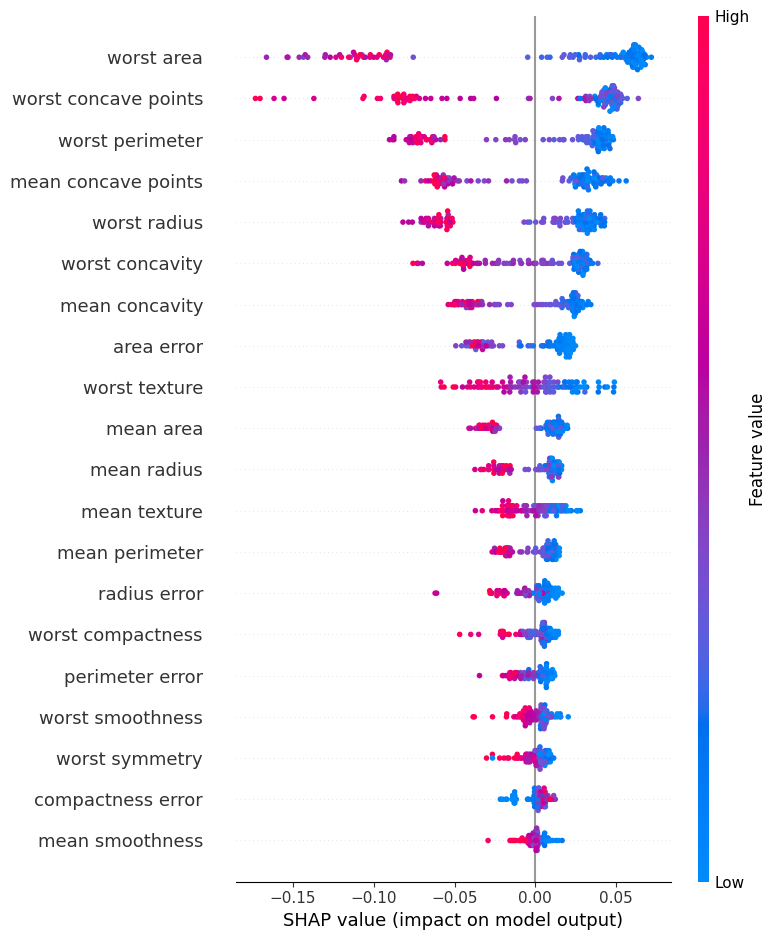

In [ ]:
shap.summary_plot(shap_values, X_test)

Here we can see the features in the test set distributed by their tendency to influence our prediction. The random forest ensemble has learned a reasonably clean partition of the space based that reflects our naive assessment of a straightforward predictor/target correlation.

## Explaining the Prediction

We'll look at a specific instance of concern which is defined here. See original [Duke XAI notebook](https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/assignments/machine_learning_court.ipynb).

In [102]:
# 🧬 Focus Instance (Tumor Misclassification - Patient X)
focus_instance = pd.DataFrame([{
    "mean radius": 13.80,
    "mean texture": 15.79,
    "mean perimeter": 90.43,
    "mean area": 584.1,
    "mean smoothness": 0.1007,
    "mean compactness": 0.1280,
    "mean concavity": 0.07789,
    "mean concave points": 0.05069,
    "mean symmetry": 0.1662,
    "mean fractal dimension": 0.06566,
    "radius error": 0.4101,
    "texture error": 1.074,
    "perimeter error": 2.635,
    "area error": 40.14,
    "smoothness error": 0.00541,
    "compactness error": 0.02204,
    "concavity error": 0.01664,
    "concave points error": 0.01185,
    "symmetry error": 0.02095,
    "fractal dimension error": 0.004902,
    "worst radius": 16.57,
    "worst texture": 20.86,
    "worst perimeter": 110.3,
    "worst area": 812.4,
    "worst smoothness": 0.1411,
    "worst compactness": 0.3542,
    "worst concavity": 0.2779,
    "worst concave points": 0.1383,
    "worst symmetry": 0.2589,
    "worst fractal dimension": 0.1030
}])


In [103]:
# Ensure perfect feature alignment with our model 
t = [ a == b for a,b in zip(df.columns[:-1], focus_instance.columns)]
assert(False not in t)

Look for this instance in our data. 

In [104]:
print("Similar instances in training data: ")
display(X_train[X_train['mean radius'] == focus_instance['mean radius'].iloc[0]]) 
print("Similar instances in test data: ")
display(X_test[X_test['mean radius'] == focus_instance['mean radius'].iloc[0]]) 

Similar instances in training data: 


Empty DataFrame
Columns: [mean radius, mean texture, mean perimeter, mean area, mean smoothness, mean compactness, mean concavity, mean concave points, mean symmetry, mean fractal dimension, radius error, texture error, perimeter error, area error, smoothness error, compactness error, concavity error, concave points error, symmetry error, fractal dimension error, worst radius, worst texture, worst perimeter, worst area, worst smoothness, worst compactness, worst concavity, worst concave points, worst symmetry, worst fractal dimension]
Index: []

[0 rows x 30 columns]

Similar instances in test data: 


mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
73         13.8         15.79           90.43      584.1           0.1007   

    mean compactness  mean concavity  mean concave points  mean symmetry  \
73             0.128         0.07789              0.05069         0.1662   

    mean fractal dimension  ...  worst radius  worst texture  worst perimeter  \
73                 0.06566  ...         16.57          20.86            110.3   

    worst area  worst smoothness  worst compactness  worst concavity  \
73       812.4            0.1411             0.3542           0.2779   

    worst concave points  worst symmetry  worst fractal dimension  
73                0.1383          0.2589                    0.103  

[1 rows x 30 columns]

In [142]:
focus_index = (X_test.index == 73).tolist().index(True)
X_test.iloc[focus_index]

mean radius                 13.800000
mean texture                15.790000
mean perimeter              90.430000
mean area                  584.100000
mean smoothness              0.100700
mean compactness             0.128000
mean concavity               0.077890
mean concave points          0.050690
mean symmetry                0.166200
mean fractal dimension       0.065660
radius error                 0.278700
texture error                0.620500
perimeter error              1.957000
area error                  23.350000
smoothness error             0.004717
compactness error            0.020650
concavity error              0.017590
concave points error         0.009206
symmetry error               0.012200
fractal dimension error      0.003130
worst radius                16.570000
worst texture               20.860000
worst perimeter            110.300000
worst area                 812.400000
worst smoothness             0.141100
worst compactness            0.354200
worst concav

We have not seen this instance before but it is in our test data. It turns out to be the lone case of a false negative inthe test set. Predict on this sample and then proceed with inference on the relationship between predictors and output. 

In [105]:
pred = model.predict(focus_instance)
print("Prediction for Patient X:", "Benign → No Biopsy" if pred[0] == 1 else "Malignant → Action Needed")

Prediction for Patient X: Benign → No Biopsy


### SHAP 

We'll apply SHAP to learn more about our focus case. 

In [288]:
shap_values = explainer(focus_instance)[:,:,1]
shap_values.shape

(1, 30)

We can inspect the explainer's internal linear model weights that communicate the role of each feature in this specific instance prediction and look at their distribution. 

In [257]:
shap_values.values[0]

array([ 0.01240643,  0.01943476,  0.01348738,  0.01213   ,  0.000975  ,
        0.00635333,  0.01594476,  0.01309095,  0.00172333,  0.00130762,
       -0.00123952,  0.00295   ,  0.00026917,  0.00287476,  0.00294   ,
        0.00336   ,  0.000545  ,  0.00333333,  0.00461131,  0.00045798,
        0.02004619,  0.04131048, -0.01459571,  0.02560881, -0.00148333,
        0.00771405,  0.0010719 ,  0.02067857,  0.0064106 , -0.00941714])

Text(0, 0.5, 'Feature count')

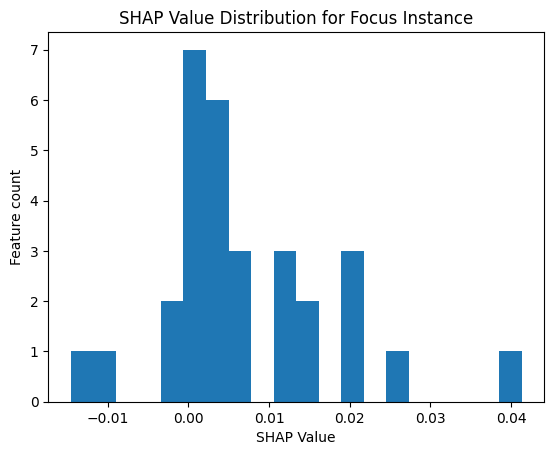

In [267]:
fig, ax = fig, ax = plt.subplots()
ax.hist(shap_values.values[0], bins=20)
ax.set_title("SHAP Value Distribution for Focus Instance")
ax.set_xlabel("SHAP Value")
ax.set_ylabel("Feature count")

We see for this example there are a few features with disproportionate impact on the benign classification. We can use a waterfall plot to see break these features out. Here the features that influenced the model toward a positive classification (benign) are shown in red and features that influenced the model toward a negative classification (malignant) are shown in below.

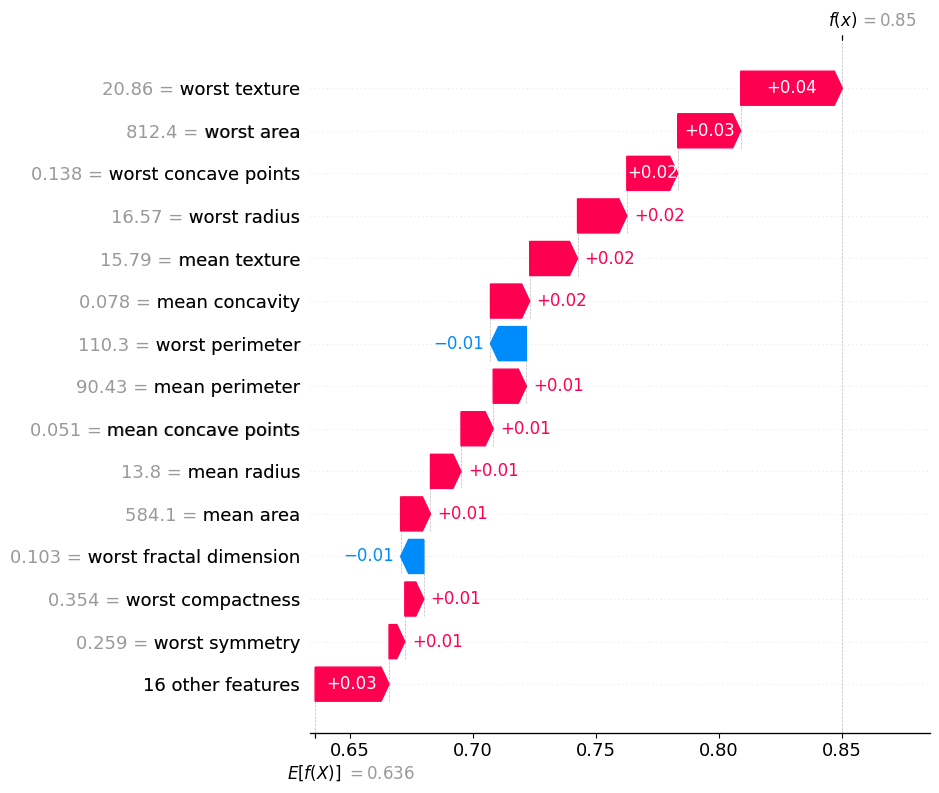

In [272]:
shap.plots.waterfall(shap_values[0], max_display=15)

We can look at the estimated response of the output as each of the most influential features vary: 

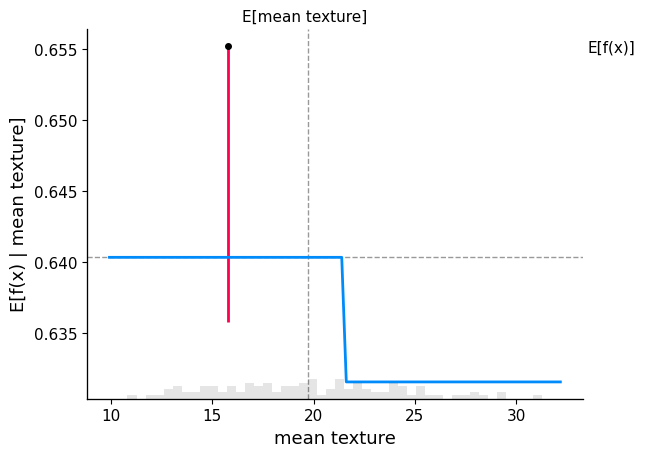

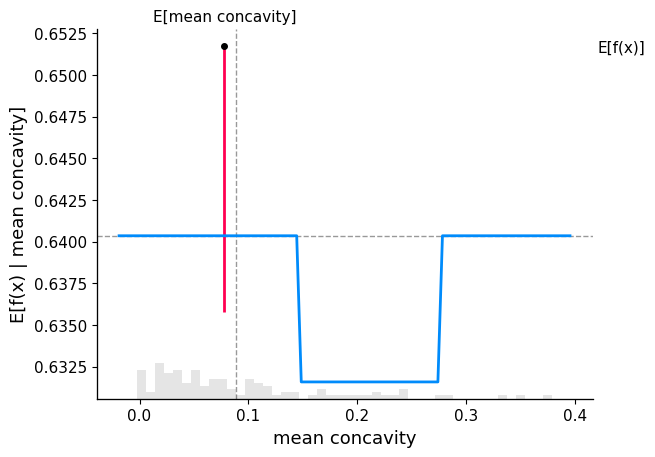

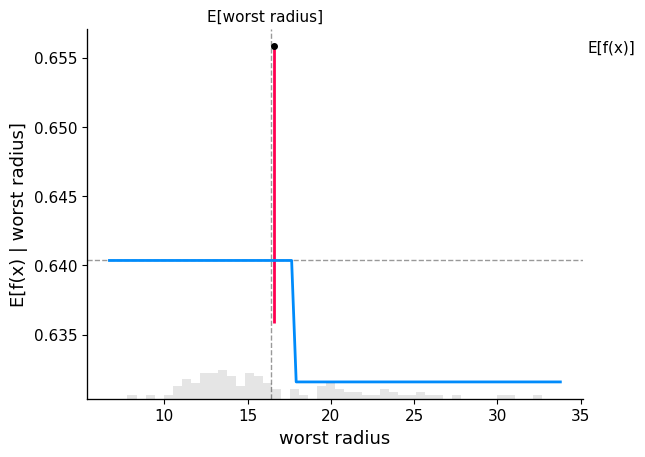

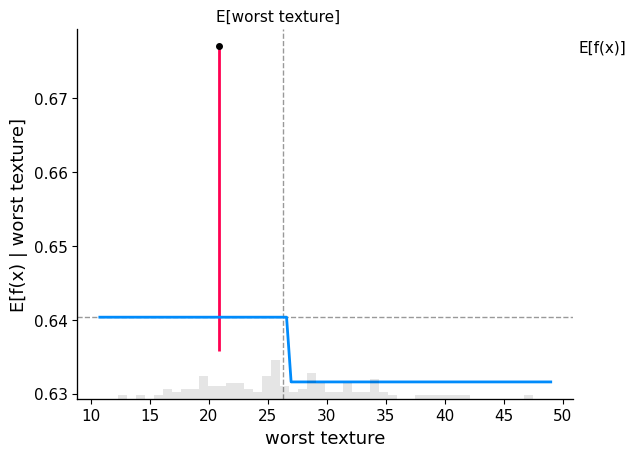

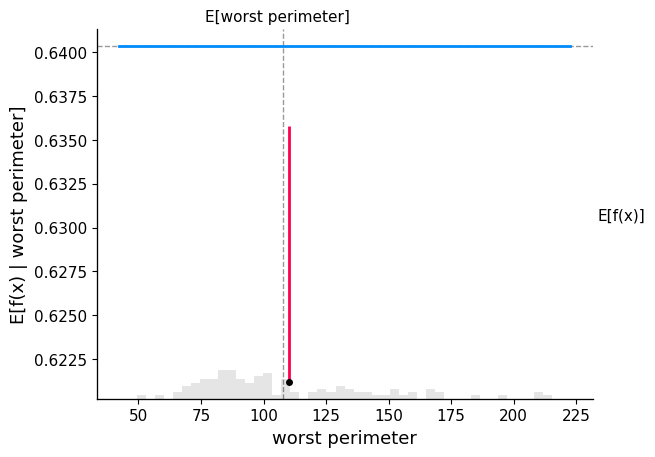

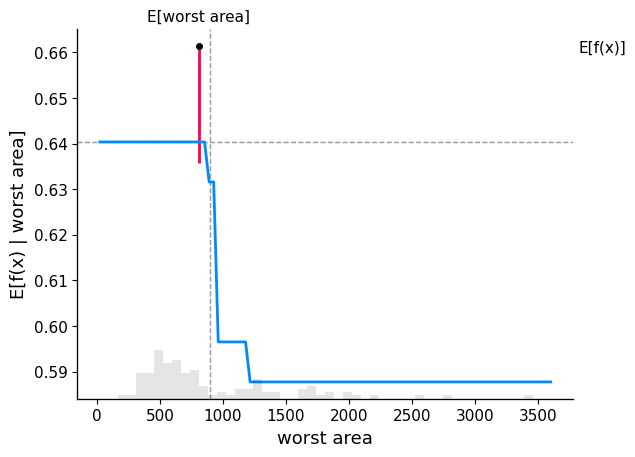

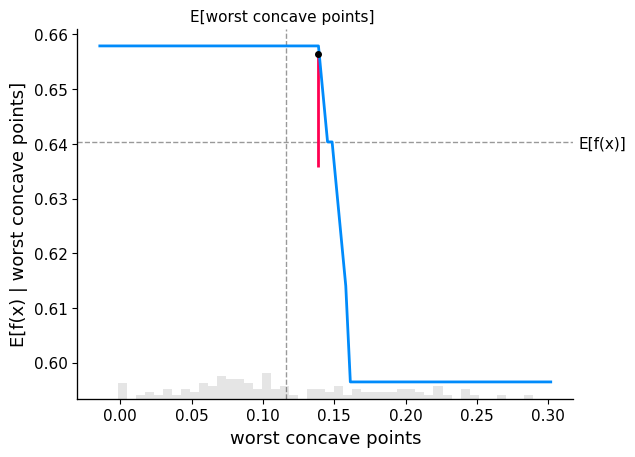

In [275]:
focus_features = [
    'worst texture', 
    'worst area', 
    'worst concave points', 
    'worst radius', 
    'mean texture', 
    'mean concavity', 
    'worst perimeter', 
    ]
for i, feature in enumerate(df.drop(['target'], axis=1).columns): 

    if feature in focus_features: 
        shap.partial_dependence_plot(
            df.columns[i], 
            model.predict,
            X_test, 
            model_expected_value=True, 
            feature_expected_value=True, 
            ice=False, 
            shap_values=shap_values
        )
        plt.show()


We can see that a number of features in the focus instance are right at the decision boundaries of the decision-tree-based ensemble model. 

### ICE

The SHAP explanations are quite useful, but reducing the full complexity of the ensemble down to a single feature importance value risks misapprehending some of the key decision points the model has learned. Going back to the beeswarm plot, we note a number of features have some mixed role in classficiation that we would like to better explain. We'll can increase our  ability to explain the global role of feauture roles with individual conditional expectation (ICE) plots. 

In [306]:
from sklearn.inspection import PartialDependenceDisplay

Let's look at the most salient features in the classification per SHAP to assess the nature of the target response to changes in each (feature). Here we plot the average value alongside the sample-specific response to help appreciate where they are aligned and where they deviate. We also highlight the focus case in red to help trace that examples

In [356]:
def trace_ice_sample(pdp:PartialDependenceDisplay, ix:int, val:float=None, desc:str=None): 
    """
    Trace a sample in an existing partial dependence plot, optionally highlighting a specific value. 

    Strategy for highlighting a line by way of gpt-5, see https://chatgpt.com/share/68d03867-72a0-8004-bfe1-88f9d73fa895
    """
    ax = pdp.axes_[0, 0]  # or however your axes are laid out

    ice_lines = pdp.lines_[0, 0]  # this is a list (or array) of line objects for sample ICE curves

    for j, line in enumerate(ice_lines):
        if j == ix:
            line.set_linewidth(2.5)
            line.set_color('blue')  # highlight color
            line.set_alpha(1.0)
            line.set_label(f"ICE curve for sample")

    print(val, desc)
    if val != None: 
        ax.axvline(x=val, color='red', linestyle='--', linewidth=1, label=desc)

    ax.legend()


20.86 sample feature value


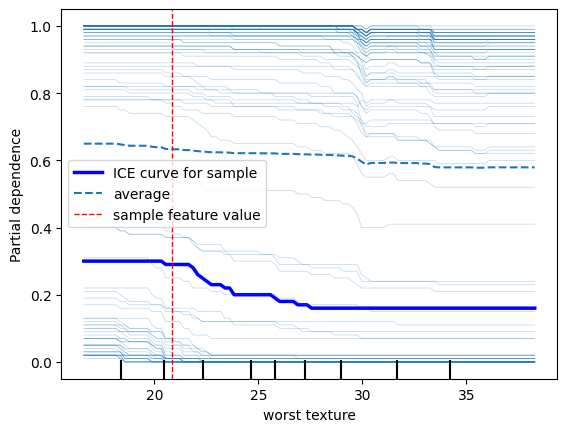

812.4 sample feature value


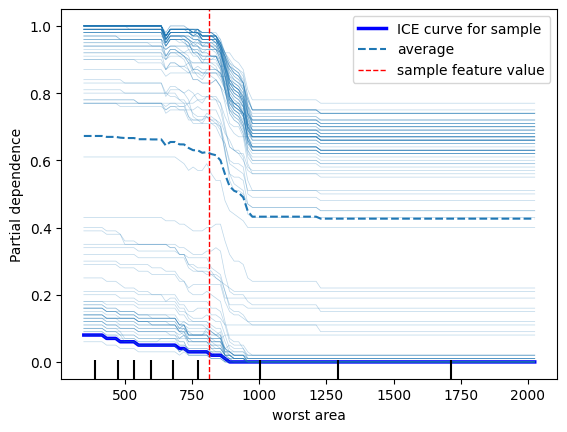

0.1383 sample feature value


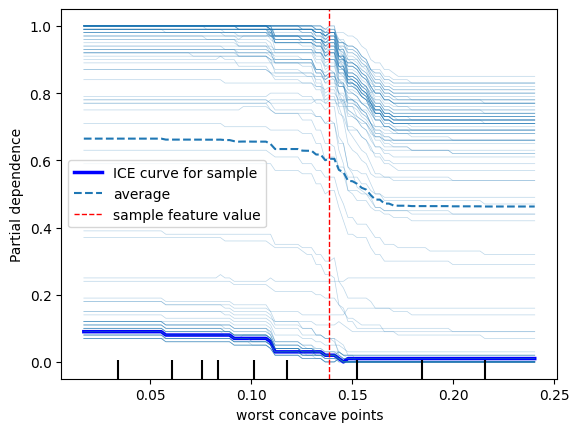

16.57 sample feature value


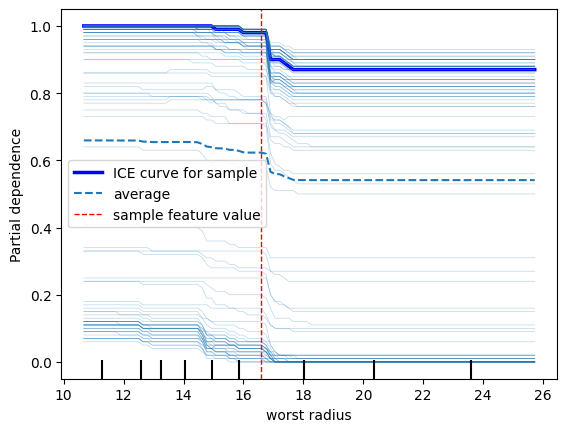

15.79 sample feature value


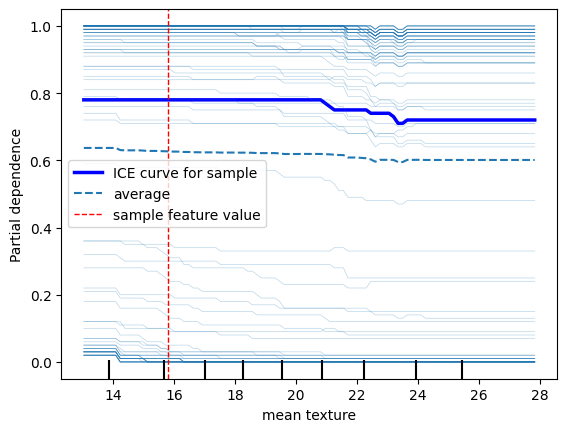

0.07789 sample feature value


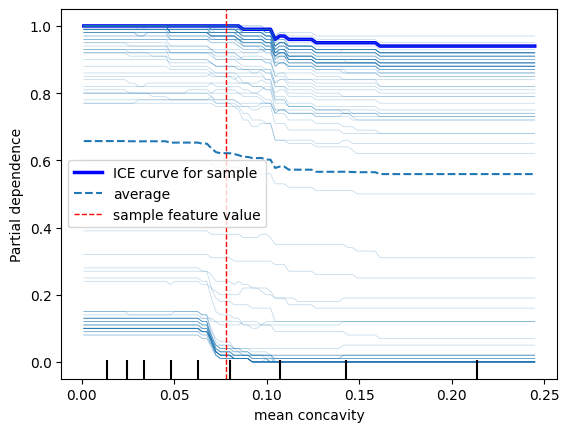

110.3 sample feature value


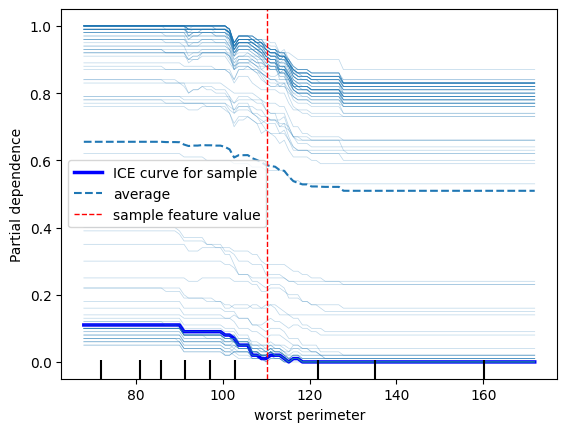

In [360]:
for feature in focus_features: 
    pdp = PartialDependenceDisplay.from_estimator(model, X_test, [feature], kind='both')
    trace_ice_sample(pdp=pdp, ix=focus_index, val=focus_instance[feature][0], desc="sample feature value")
    plt.show()

These plots reinforce that for two of the three most prominent features (*worst area* and *worst concave points*) that the sample sits right at the margin of the ensemble's decision boundary. 

## Discussion

For the test sample of interest, we have a number of features that are teetering right on the benign edge of the decision boundary. This suggests perhaps some or all of the following: 
- more features are required to disambiguate these cases during training
- more sensivity might improve outcomes, which could be achieved with a differnt model or hyperparameter tuning of the random forest ensemble 
- this test case and cases like it were not suitably represented in the training data 
- that an unobserved factor drives the phenomenon we are trying to model and we are condemned to always misclassify a subset of cases

Ultimately, while small consolation to individuals whose biopsies are misclassifed, at the outset the trained model was advertised with an imperfect precision and recall. The interpretation is that we will have some false positives (malignant cases declared clear) and false negatives (benign cases declared malignant). These are conveyed respectively in the precision and recall numbers that should be made available with the model prior to application. For the case in question, the precision number is compelling at 0.96 but not infallible. This raises the essential nature of pairing model observations with human domain expertise and suitable contextualization of model predictions. That is, the model is a tool, and like any tool needs to be used appropriately and have its shortcomings mitigated with other interventions. The existence of false positives and false negatives is a par for the course for this type of binary classification task. 